# **Emotion Classificaton in Text**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# General
import numpy as np
import pandas as pd
import re

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
# plt.style.use('dark_background')

try:
  import pyprind
except Exception:
  !pip install pyprind
  import pyprind

# Data preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# SKLEARN 
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from scipy.special import softmax


from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading the data

In [2]:
# set the seed for entire process
# so that results can be reproducible
np.random.seed(123)

dataset = pd.read_csv("/content/drive/My Drive/emotion.data")
dataset.drop(dataset.columns[0], axis='columns', inplace=True)    # drop id column since it won't be used 
dataset = dataset.reindex(np.random.permutation(dataset.index))   # shuffle data 
dataset.head()

,text,emotions
302608,i am taking an acid reducer every day and then...,love
283216,i feel gratitude towards those sweet beautiful...,love
266948,i had slept late into the afternoon and awoke ...,joy
391788,i cant tell you how many parent conferences we...,anger
227726,i feel like im slaughtering the tender feeling...,love


# Visualization

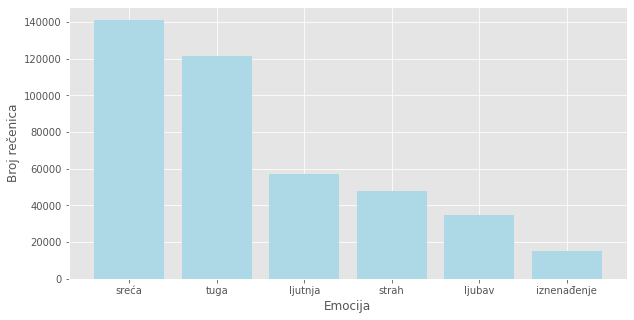

In [4]:
#x_ax = np.unique(dataset['emotions'])                             # more general way
x_ax = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']     # I did it by hand so the values are sorted
x_ax2 = ['sreća', 'tuga', 'ljutnja', 'strah', 'ljua']
y_ax = [ np.count_nonzero(dataset['emotions'] == x) for x in x_ax]

fig = plt.figure(figsize=(10, 5))
plt.bar(x_ax, y_ax, color='lightblue')
plt.title("Distribution of emotions in dataset")
plt.xlabel("Emotion")
plt.ylabel("Number of occurences")
# plt.savefig('/content/drive/My Drive/Colab Notebooks/individual/distribution.png')
plt.show()

## Word clouds

In [0]:
from wordcloud import WordCloud

def generate_word_cloud(input_text):
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(input_text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [0]:
############### INDIVIDUAL PLOTS

fig = plt.figure(figsize=(15, 8))

emotion = 'love'

df = dataset.loc[dataset['emotions'] == emotion]
df = df['text'].tolist()
wordcloud = WordCloud(max_font_size=80).generate(" ".join(df))
plt.axis("off")
plt.title(emotion)
plt.imshow(wordcloud)

#plt.savefig('/content/drive/My Drive/Colab Notebooks/individual/' + emotion +'.png')
plt.show()


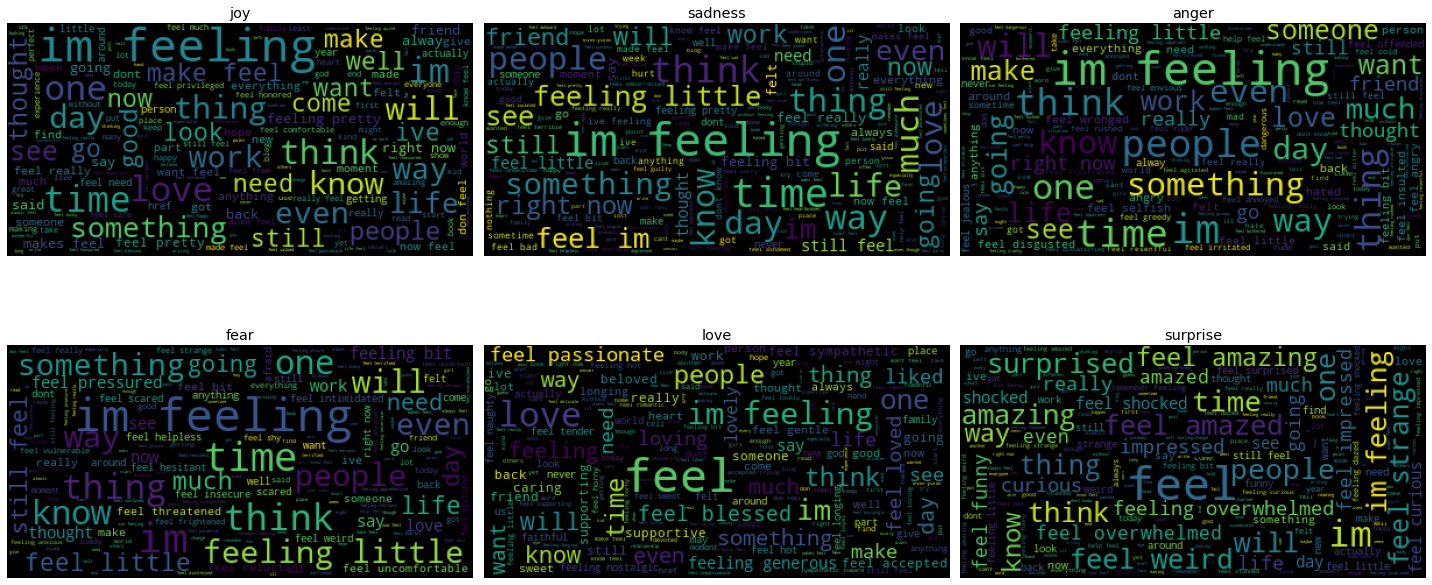

In [0]:
fig = plt.figure(figsize=(20, 10))

for idx,emotion in enumerate(x_ax):
  ax = fig.add_subplot(2, 3, idx+1)
  df = dataset.loc[dataset['emotions'] == emotion]
  df = df['text'].tolist()
  wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(" ".join(df))
  ax.axis("off")
  ax.set_title(emotion)
  ax.imshow(wordcloud)

plt.tight_layout()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/wc_facet.png')
plt.show()

# Preprocessing


 ## Stop words


In [0]:
try:
  stop = stopwords.words('english')
except LookupError:
  import nltk
  nltk.download('stopwords')
  stop = stopwords.words('english')

stop.extend(['img', 'src', 'href'])     # some of these appear in given dataset
print(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [0]:
# [stop.remove(x) for x in ['no', 'not']]
stop

## Tokenezing

In [0]:

def tokenizer(text):
    ''' Removes stop words and special characters,
        and returns list of all words that are left

        Parameters
        -----------
        text : string 

        Returns
        ----------
        tokenized : list {string}
    '''

    text = re.sub('http.*', '', text)                               # delete link references
    text = re.sub('[\W]+', ' ', text.lower()).replace('-', '')      # delete non-word characters [^a-zA-Z0-9]
    tokenized = [w for w in text.split() if w not in stop]          # delete stop words ( I, me , a, the)
    return tokenized


In [0]:
string = 'check out this link http://www.gocml is it nice'
import re
re.sub('http.*[" "\n\t]', '', string)

'check out this link nice'

## Stemming


In [0]:
porter = PorterStemmer() 
def tokenizer_porter(text):
  return [porter.stem(word) for word in tokenizer(text)]

# Creating Train and test data

In [0]:
label2id = {"joy" : 0, "sadness" : 1, "anger" : 2, "fear" : 3, "love" : 4, "surprise" : 5}
id2label = {0 : "joy", 1 : "sadness", 2 : "anger", 3 : "fear", 4 : "love", 5 : "surprise"}

label2col = {"joy":"yellow", "sadness":"blue", "anger":"red", "fear":"grey", "love":"pink", "surprise":"orange"}

#label2id = { label : idx for idx, label in enumerate(set(dataset['emotions'].values))}
#id2label = { id : label for label, id in label2id.items()}

print(label2id)
print(id2label)

{'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}
{0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['text'].values, 
                                                    dataset['emotions'].values, 
                                                    test_size=0.1, 
                                                    random_state=123)
X_train

array(['i begun to feel homesick',
       'i was feeling emotionally lethargic and i was bordering on depression',
       'i become upset because i already feel like i miss out on so much and i tell him that i feel like i m being punished for having a job he doesn t have one',
       ...,
       'i feel like im really settling into my life here and like im finally back in the spain that ive missed for more than years',
       'i feel the need to memorialize my beloved cat a tree possibly with his ashes under it',
       'i hurt went on and found someone more worthwhile so why when i cast my mind back to those times does it still make me feel ashamed'],
      dtype=object)

In [0]:
y_train = np.asarray([ label2id[val] for val in y_train])
y_test =  np.asarray([ label2id[val] for val in y_test])          

# Training the model


## Vectorization

In [0]:
# Hashing vectorizer
lr_vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**18,
                         preprocessor=None, 
                         tokenizer=tokenizer)

## Logistic Regression

In [0]:
# By setting the loss parameter to log loss this becomes a Logistic Regression Classifier
lr_clf = SGDClassifier(loss='log', random_state=123, max_iter=1)

num_epochs = 100
pbar = pyprind.ProgBar(num_epochs)
classes = [x for x in label2id.values()]

for i in range(num_epochs):

    # number of elements in one batch
    size = int(len(X_train) / num_epochs)

    #starting index of a batch
    start = size * i

    #last index of a batch
    end = start + size 

    batch_x = X_train[start : end]
    batch_y = y_train[start : end]

    batch_x = lr_vect.transform(batch_x)
    lr_clf.partial_fit(batch_x, batch_y, classes=classes)
    pbar.update()

# some elements are possibly left over because of integer division
# so do one final partial fit
batch_x = X_train[end : ]
batch_y = y_train[end : ]

batch_x = lr_vect.transform(batch_x)
lr_clf.partial_fit(batch_x, batch_y, classes=classes)
pbar.update()


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:24


In [0]:
def calculate_metrics(clf, vect):
  transformed = vect.transform(X_test)
  y_pred = clf.predict(transformed)

  # Calculate F-Score
  print(classification_report(y_test, y_pred))

  # Calculate Accuracy
  print('Accuracy: %.3f' % clf.score(transformed, y_test))

In [0]:
print("\nLogistic Regression: \n")

calculate_metrics(lr_clf, lr_vect)


Logistic Regression: 

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     14156
           1       0.87      0.95      0.90     12141
           2       0.92      0.78      0.84      5678
           3       0.87      0.69      0.77      4813
           4       0.93      0.51      0.66      3405
           5       0.93      0.35      0.51      1489

    accuracy                           0.85     41682
   macro avg       0.89      0.71      0.76     41682
weighted avg       0.86      0.85      0.84     41682

Accuracy: 0.846


## SVM Approach

### TF IDF


In [0]:
# TF-IDF vectorizer
tfidf_vect = TfidfVectorizer(tokenizer=tokenizer)

# Linear SVC classifier 
tfidf_clf = LinearSVC()
tfidf_clf.fit(tfidf_vect.fit_transform(X_train), y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
## obrisi kasnije cell

# tfidf_vect.fit_transform(X_test).shape

x = tfidf_vect.transform(["this is a sentence"])

x

<1x24768 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [0]:
print("\nLinear SVC with TF-IDF:\n")

calculate_metrics(tfidf_clf, tfidf_vect)


Linear SVC with TF-IDF:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     14156
           1       0.94      0.94      0.94     12141
           2       0.90      0.89      0.90      5678
           3       0.83      0.83      0.83      4813
           4       0.74      0.73      0.74      3405
           5       0.70      0.69      0.69      1489

    accuracy                           0.89     41682
   macro avg       0.84      0.83      0.83     41682
weighted avg       0.89      0.89      0.89     41682

Accuracy: 0.886


### Bigrams

In [0]:
# Bigram vectorizer
bigram_vect = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer)

# Linear SVC classifier
bigram_clf = LinearSVC()
bigram_clf.fit(bigram_vect.fit_transform(X_train), y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
print("\nLinear SVC with Bigrams\n")

calculate_metrics(bigram_clf, bigram_vect)


Linear SVC with Bigrams

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     14156
           1       0.94      0.95      0.94     12141
           2       0.90      0.90      0.90      5678
           3       0.83      0.82      0.82      4813
           4       0.69      0.70      0.70      3405
           5       0.66      0.67      0.67      1489

    accuracy                           0.88     41682
   macro avg       0.82      0.82      0.82     41682
weighted avg       0.88      0.88      0.88     41682

Accuracy: 0.882


## Naive Bayes


In [0]:
from sklearn.naive_bayes import MultinomialNB


nb_clf = MultinomialNB()
nb_vect = CountVectorizer()
nb_clf.fit(nb_vect.fit_transform(X_train), y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
calculate_metrics(nb_clf, nb_vect)

              precision    recall  f1-score   support

           0       0.85      0.93      0.89     14156
           1       0.87      0.94      0.90     12141
           2       0.91      0.84      0.87      5678
           3       0.84      0.81      0.82      4813
           4       0.81      0.62      0.70      3405
           5       0.84      0.37      0.51      1489

    accuracy                           0.86     41682
   macro avg       0.85      0.75      0.78     41682
weighted avg       0.86      0.86      0.86     41682

Accuracy: 0.862


In [0]:
x = nb_clf.predict(nb_vect.transform(['I am surprised!']))
x[0]

5

### KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier


knn_clf = KNeighborsClassifier(n_neighbors=7)
knn_vect = CountVectorizer()
knn_clf.fit(knn_vect.fit_transform(X_train), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [0]:
calculate_metrics(knn_clf, knn_vect)

KeyboardInterrupt: ignored

# Evaluating models' performance


## Error

In [0]:
def missclassified(emotion, clf=tfidf_clf, vect=tfidf_vect, num=10):
  transformed = vect.transform(X_test)
  y_pred = clf.predict(transformed)

  bool_val_list = y_pred != y_test
  indices = [ idx for idx, log_val in enumerate(y_pred != y_test) if log_val]

  #ne valja
  return [ (text, id2label[y_pred[idx]], id2label[y_test[idx]]) for idx,text in enumerate(X_test[y_pred != y_test]) 
          if idx < num and y_test[idx] == label2id[emotion] ]

In [0]:
transformed = tfidf_vect.transform(X_test)
y_pred = tfidf_clf.predict(transformed)
y_pred != y_test
indices = [ idx for idx, log_val in enumerate(y_pred != y_test) if log_val]
indices

[ (X_test[x], id2label[y_pred[x]], id2label[y_test[x]])  for x in indices][:5]

[('i can choose to feel overwhelmed and sorry for myself or i can shake it off and move forward because that s what needs to happen and as an extra bonus maybe teach my kids some good traits along the journey',
  'sadness',
  'surprise'),
 ('i always had a sinking feeling that there were lots of unprotected urls exposed by zope that i may or may not have secured properly',
  'sadness',
  'fear'),
 ('i feel miserable insecure weak', 'fear', 'sadness'),
 ('i feel to have doubted such an amazing shoe', 'surprise', 'joy'),
 ('i was left feeling completely enraged and utterly devastated at the cruelty',
  'sadness',
  'anger')]

In [0]:
missclassified('joy')

[('i can choose to feel overwhelmed and sorry for myself or i can shake it off and move forward because that s what needs to happen and as an extra bonus maybe teach my kids some good traits along the journey',
  'joy',
  'joy'),
 ('i feel to have doubted such an amazing shoe', 'joy', 'joy'),
 ('i was left feeling completely enraged and utterly devastated at the cruelty',
  'joy',
  'joy'),
 ('i feel a shame before god and before the beloved', 'joy', 'joy')]

## Testing on custom data

In [0]:
def predict(text, clf=tfidf_clf, vectorizer=tfidf_vect):
  ''' Predicts the label of the given text input

  Parameters
  ----------- 
  text : string
    text whose emotion we want to interpret
  clf : sklearn.linear_model
    Classifier
  vectorizer : sklearn.feature_extraction.text
    Vectorizer that represents text in a numerical form
  
  Returns 
  ----------
  label : string
    name of emotion which corresponds to the input

  '''

  #val = clf.predict(vectorizer.transform([text]))
  #return id2label[val[0]]


  arr = clf.decision_function(vectorizer.transform([text]))
  arr = softmax(arr[0])
  bar = plt.bar(x_ax, arr.tolist(), color='lightblue')
  # [bar[idx].set_color(label2col[emotion]) for idx, emotion in enumerate(x_ax)]
  plt.show()

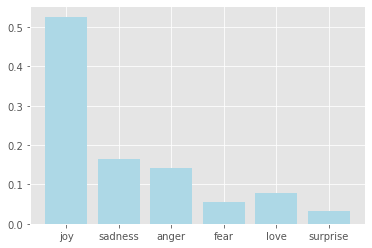

In [0]:
predict("Today has been a disaster so far", clf=lr_clf, vectorizer=lr_vect)

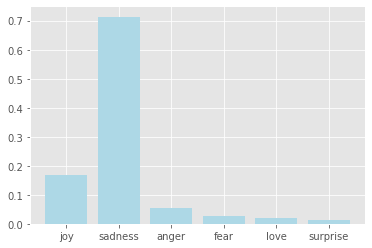

In [0]:
predict("Today has been a disaster so far. I feel so tired because my stupid boss made me do all his work", clf=lr_clf, vectorizer=lr_vect)

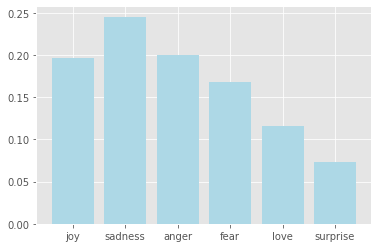

In [0]:
# Same as #1 only now using tfidf svm
predict("Today has been a disaster so far")

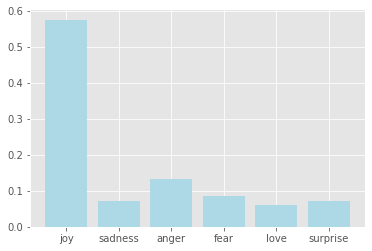

In [0]:
predict("The cucumber looked great, but when I peeled it off, some of it fell apart. But the rest still tasted fine I guess")

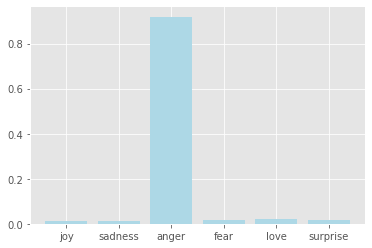

In [0]:
predict("My mom is so stubborn she won't let me go anywhere!")

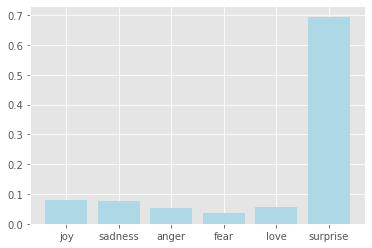

In [0]:
predict("When I found out Kobe Bryant died, i was shocked!")

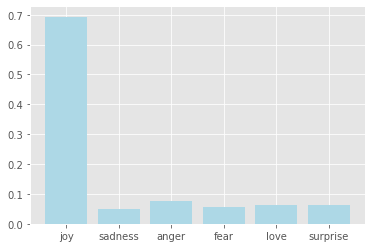

In [0]:
predict("I am not happy")

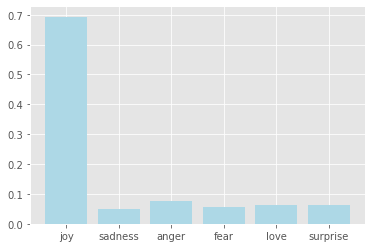

In [0]:
predict("I am not happy", tfidf_clf, tfidf_vect)

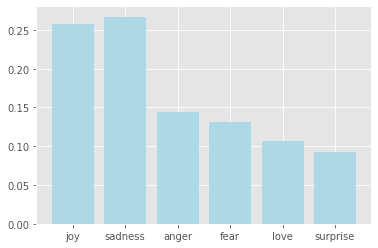

In [0]:
predict("I am not happy", bigram_clf, bigram_vect)

In [0]:
bigram_clf.decision_function(bigram_vect.transform(['I am not happy']))

array([[-0.22751951, -0.19147681, -0.80843556, -0.90200089, -1.10799806,
        -1.24391444]])